In [1]:
!pip install lifelines
!pip install dgl
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dgl
import torch
import torch.nn.functional as F
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from dgl.data import DGLDataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#data = pd.read_csv("/content/drive/MyDrive/01-Classes/08Semester/CSDS491/CSDS491CourseProject/data/train.csv") #Sakin's directory
data = pd.read_csv("/content/drive/MyDrive/Case/Graph Class/train.csv") #Josh's directory
data.head()

,Unnamed: 0,MassScore,VolumeScore,Area2D,NumLesion3D,isAgZero,isLesion3DBelow5,AgGroupX1,AgGroupX2,AgGroupX3,...,female,smokingstatus,Baseline.BMI,IBD,SLE,Psoriasis,RA,BASELINE_DM,DM,Status
0,0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,33.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,11.391991,95.593929,38.623810,12.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,36.50,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,2,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,30.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,21.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,14.425980,76.675415,30.975342,3.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,33.76,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.shape

(3366, 75)

In [6]:
data.columns

Index(['Unnamed: 0', 'MassScore', 'VolumeScore', 'Area2D', 'NumLesion3D',
       'isAgZero', 'isLesion3DBelow5', 'AgGroupX1', 'AgGroupX2', 'AgGroupX3',
       'numLesionPerArtery3D_LM1', 'numLesionPerArtery3D_LAD1',
       'numLesionPerArtery3D_LCX1', 'numLesionPerArtery3D_RCA1', 'isArt2plus',
       'isArt3plus', 'numArtCalc', 'AgastonScorePerArtery2D_LM1',
       'AgastonScorePerArtery2D_LAD1', 'AgastonScorePerArtery2D_LCX1',
       'AgastonScorePerArtery2D_RCA1', 'MassScorePerArtery_LM1',
       'MassScorePerArtery_LAD1', 'MassScorePerArtery_LCX1',
       'MassScorePerArtery_RCA1', 'VolumeScorePerArtery_LM1',
       'VolumeScorePerArtery_LAD1', 'VolumeScorePerArtery_LCX1',
       'VolumeScorePerArtery_RCA1', 'massHist1', 'massHist2', 'massHist3',
       'massHist4', 'massHist5', 'avrHist1', 'avrHist2', 'avrHist3',
       'avrHist4', 'avrHist5', 'DistTop2LastLesionPerArtery_LM1',
       'DistTop2LastLesionPerArtery_LAD1', 'DistTop2LastLesionPerArtery_LCX1',
       'DistTop2LastLesion

In [7]:
data.iloc[[0]]

,Unnamed: 0,MassScore,VolumeScore,Area2D,NumLesion3D,isAgZero,isLesion3DBelow5,AgGroupX1,AgGroupX2,AgGroupX3,...,female,smokingstatus,Baseline.BMI,IBD,SLE,Psoriasis,RA,BASELINE_DM,DM,Status
0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,33.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data.size

252450

In [9]:
class MACEDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='MACE')

    def process(self):
        MACEData=data
        # edges = pd.read_csv('./graph_edges.csv')
        # properties = pd.read_csv('./graph_properties.csv')
        self.graphs = []
        self.labels = []
        self.time = []
        self.dim_nfeats = 0
        self.gclasses=1

        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        length=len(MACEData)
        rows=[]
        cols=[]


        connections=[['female','smokingstatus'],['female','Baseline.BMI'],['Age_right','BASELINE_DM'],
['Age_right','smokingstatus'],['BASELINE_DM','MassScore'],
['Age_right','SLE'],['Age_right','Psoriasis'],['Age_right','RA'],['Age_right','IBD'],
['female','Age_right'],
['female','MassScore'],['female','Baseline.BMI'],
['BASELINE_DM','MassScore'],['DM','MassScore'],
['isAgZero','MassScore'],['isAgZero','final_score'],
['MassScore','isArt2plus'],['MassScore','isArt3plus'],['MassScore','numArtCalc'],
['numArtCalc','numLesionPerArtery3D_LM1'],['numArtCalc','numLesionPerArtery3D_LAD1'],['numArtCalc','numLesionPerArtery3D_LCX1'],['numArtCalc','numLesionPerArtery3D_RCA1'],
['MassScore','numLesionPerArtery3D_LM1'],['MassScore','numLesionPerArtery3D_LAD1'],['MassScore','numLesionPerArtery3D_LCX1'],['MassScore','numLesionPerArtery3D_RCA1'],
['numLesionPerArtery3D_LM1','AgastonScorePerArtery2D_LM1'],['numLesionPerArtery3D_LAD1','AgastonScorePerArtery2D_LAD1'],['numLesionPerArtery3D_LCX1','AgastonScorePerArtery2D_LCX1'],['numLesionPerArtery3D_RCA1','AgastonScorePerArtery2D_RCA1'],
['numLesionPerArtery3D_LM1','MassScorePerArtery_LM1'],['numLesionPerArtery3D_LAD1','MassScorePerArtery_LAD1'],['numLesionPerArtery3D_LCX1','MassScorePerArtery_LCX1'],['numLesionPerArtery3D_RCA1','MassScorePerArtery_RCA1'],
['numLesionPerArtery3D_LM1','VolumeScorePerArtery_LM1'],['numLesionPerArtery3D_LAD1','VolumeScorePerArtery_LAD1'],['numLesionPerArtery3D_LCX1','VolumeScorePerArtery_LCX1'],['numLesionPerArtery3D_RCA1','VolumeScorePerArtery_RCA1'],
['numLesionPerArtery3D_LM1','DistTop2LastLesionPerArtery_LM1'],['numLesionPerArtery3D_LAD1','DistTop2LastLesionPerArtery_LAD1'],['numLesionPerArtery3D_LCX1','DistTop2LastLesionPerArtery_LCX1'],['numLesionPerArtery3D_RCA1','DistTop2LastLesionPerArtery_RCA1'],
['numLesionPerArtery3D_LM1','DistFirst2LastLesionPerArtery_LM1'],['numLesionPerArtery3D_LAD1','DistFirst2LastLesionPerArtery_LAD1'],['numLesionPerArtery3D_LCX1','DistFirst2LastLesionPerArtery_LCX1'],['numLesionPerArtery3D_RCA1','DistFirst2LastLesionPerArtery_RCA1'],
['MassScore','massHist1'],['MassScore','massHist2'],['MassScore','massHist3'],['MassScore','massHist4'],['MassScore','massHist5'],
['VolumeScore','avrHist1'],['VolumeScore','avrHist2'],['VolumeScore','avrHist3'],['VolumeScore','avrHist4'],['VolumeScore','avrHist5'],
['Area2D','NumLesion3D'],['Area2D','VolumeScore'],
['MassScore','NumLesion3D'],
['isLesion3DBelow5','NumLesion3D'],
['final_score','AgGroupX1'], ['AgGroupX2','final_score'], ['AgGroupX3','final_score'],
['AgGroupX1','ICfirstMomentH1'],['AgGroupX2','ICfirstMomentH2'],['AgGroupX3','ICfirstMomentH3'],
['AgGroupX1','ICsecondMomentH1'],['AgGroupX2','ICsecondMomentH2'],['AgGroupX3','ICsecondMomentH3'],
['AgGroupX1','ICmeanMomentH1'],['AgGroupX2','ICmeanMomentH2'],['AgGroupX3','ICmeanMomentH3'],
['AgGroupX1','ICskewnesstMomentH1'],['AgGroupX2','ICskewnesstMomentH2'],['AgGroupX3','ICskewnesstMomentH3'],
['AgGroupX1','ICkurtosisMomentH1'],['AgGroupX2','ICkurtosisMomentH2'],['AgGroupX3','ICkurtosisMomentH3']
]
        MACEData=MACEData.drop(['Time','Status','Unnamed: 0'],axis=1)

        for i in connections:
          rows.append(MACEData.columns.get_loc(i[0]))
          cols.append(MACEData.columns.get_loc(i[1]))
          i[0]=MACEData.columns.get_loc(i[0])
          i[1]=MACEData.columns.get_loc(i[1])

        for i in range(length):
            x=MACEData.iloc[[i]]
            label_dict = {}
            num_nodes_dict = {}
            g = dgl.graph((rows, cols), num_nodes=np.size(x))
            edges=g.edges()
            parent=np.unique(np.array(edges[0]))
            child=np.unique(np.array(edges[1]))
            leaf=np.setdiff1d(parent,child)

            feats=np.unique(connections)
            self.dim_nfeats=len(feats)
            featarray=np.zeros([len(feats),len(x)+1])
            g.ndata['h']=torch.rot90(torch.tensor(x.to_numpy()),1,[1,0]).float()
            #g = dgl.add_self_loop(g)
            self.graphs.append(g)
            self.labels.append([data['Status'][i]])
            self.time.append([data['Time'][i]])
            
            

        # Convert the label list to tensor for saving.
        self.labels = torch.tensor(self.labels)
        self.time = torch.tensor(self.time)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [10]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

In [11]:
dataset = MACEDataset()


<ipython-input-12-1744a6972721>:4: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  viz = graphviz_layout(nxgraph, prog="twopi")


Graph(num_nodes=72, num_edges=79,
      ndata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={}) tensor([1.], dtype=torch.float64)


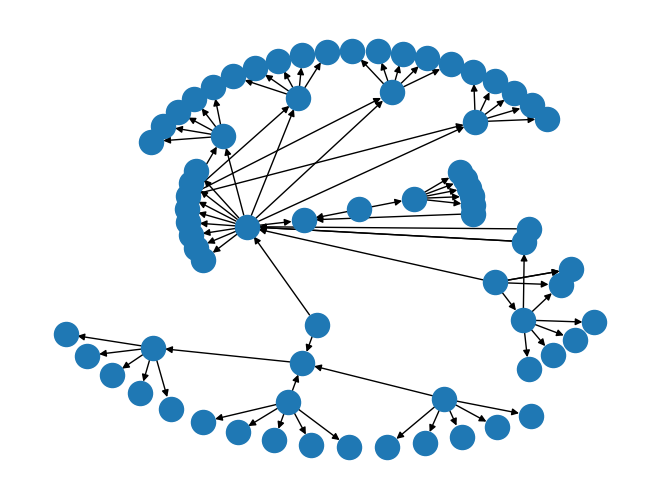

In [12]:
graph, label = dataset[1]
edges=graph.edges()
nxgraph=dgl.to_networkx(graph)
viz = graphviz_layout(nxgraph, prog="twopi")
nx.draw(nxgraph,pos=viz)
print(graph, label)

In [13]:
print(graph)
print(label)
graph.ndata['h'].shape

Graph(num_nodes=72, num_edges=79,
      ndata_schemes={'h': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})
tensor([1.], dtype=torch.float64)


torch.Size([72, 1])

In [14]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler #, WeightedRandomSampler


num_examples = len(dataset)
num_train = int(num_examples * 0.8)

x=np.arange(0,len(dataset))
np.random.shuffle(x)
a=x[np.arange(num_train)]
b=x[torch.arange(num_train, num_examples)]
train_sampler = SubsetRandomSampler(a)
test_sampler = SubsetRandomSampler(b)

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=10, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=10, drop_last=False)

In [15]:
it = iter(train_dataloader)
batch = next(it)
#print(batch)

In [16]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
#print('The original graphs in the minibatch:')
#print(graphs)

Number of nodes for each graph element in the batch: tensor([72, 72, 72, 72, 72, 72, 72, 72, 72, 72])
Number of edges for each graph element in the batch: tensor([79, 79, 79, 79, 79, 79, 79, 79, 79, 79])


# Model Construction

In [17]:
from dgl.nn import GraphConv

class GCN(torch.nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.conv3 = GraphConv(h_feats, num_classes)
        self.classify = torch.nn.Linear(h_feats, num_classes)
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        #h = self.conv3(g, h)
        #h = torch.relu(h)
        #print(h.shape)
        with g.local_scope():
          g.ndata['out'] = h 
          hg = dgl.mean_nodes(g, 'out') #aggreagate node features using MLP!!!!!!!!!!!!!!!!!!!!!
          #print(max(h),min(h))
          #g.update_all(dgl.function.u_mul_e('out1', 'DistTop2Lesion', 'm'),dgl.function.mean('m', 'out')) 
          #g.update_all(dgl.function.u_mul_e('out', 'DistTop2Lesion', 'm'),dgl.function.mean('m', 'out')) 
          #print(np.shape(h))
          #print(dgl.mean_nodes(g, 'out').float())
          
          return F.sigmoid(self.classify(hg)) #max nodes

# Model Training

In [18]:
#Cross Validation
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True)

num_epochs=100
train_acc=np.zeros([5,num_epochs])
auc=np.zeros([5,num_epochs])
test_acc=np.zeros([5,num_epochs])
train_loss=np.zeros([5,num_epochs])

for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print('Fold',fold+1)
  print('---------------------------------')
  train_sampler = SubsetRandomSampler(train_ids)
  test_sampler = SubsetRandomSampler(test_ids)

  train_dataloader = GraphDataLoader(
      dataset, sampler=train_sampler, batch_size=1, drop_last=False)
  test_dataloader = GraphDataLoader(
      dataset, sampler=test_sampler, batch_size=1, drop_last=False)

  # Create the model with given dimensions
  model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
  optimizer = torch.optim.Adam(model.parameters(), lr=.001)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

  for epoch in range(num_epochs):
      batch_loss=[];
      train_num_correct = 0
      num_trains = 0
      preds=np.array([])
      labels=np.array([])
      for batched_graph, label in train_dataloader:
          pred = model(batched_graph, torch.rot90(batched_graph.ndata['h'],1,[1,0]))
          train_preds= np.append(preds,pred.detach().numpy())
          train_num_correct += ((pred>0) == label).sum().item()
          labels = np.append(labels,label.detach().numpy())
          num_trains += len(label)
          pred_class=torch.stack((1-pred,pred),dim=1)
          loss = F.binary_cross_entropy(pred,label.float()) 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          scheduler.step()
          batch_loss.append(loss)
      train_loss[fold,epoch]=sum(batch_loss)/len(batch_loss)
      num_correct = 0
      num_tests = 0
      preds=np.array([])
      labels=np.array([])
      for batched_graph, label in test_dataloader:
          pred = model(batched_graph, torch.rot90(batched_graph.ndata['h'],1,[1,0]))
          preds= np.append(preds,pred.detach().numpy())
          num_correct += ((pred>0.5) == label).sum().item()
          labels = np.append(labels,label.detach().numpy())
          num_tests += len(label)
      #fpr, tpr, thresholds=metrics.roc_curve(labels,preds)
      #auc[fold,epoch] = metrics.roc_auc_score(labels, preds)
      train_acc[fold,epoch]=train_num_correct / num_trains
      test_acc[fold,epoch]=num_correct / num_tests
      if epoch % 10==0:
        print('Epoch:',epoch,'| train_loss',train_loss[fold,-1],'| train accuracy',train_num_correct / num_trains,'| Test accuracy:', num_correct / num_tests)

Fold 1
---------------------------------


DGLError: ignored

In [ ]:
for fold in range(5):  
  plt.plot(np.arange(0,num_epochs),train_loss[fold],label=('fold'+str(fold))) 
plt.plot(np.arange(0,num_epochs),np.mean(train_loss,0),label=('Total')) 
plt.legend()
plt.title('Train Loss per Epoch')
#2-fold validation
#10-fold validation

In [ ]:
import sklearn.metrics as metrics

In [ ]:
fpr, tpr, thresholds=metrics.roc_curve(labels,preds)
auc = metrics.roc_auc_score(labels, preds)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)